In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

In [61]:
fast = np.loadtxt('data/epics_fast.txt')
slow = np.loadtxt('data/epics_slow.txt')

In [62]:
from astropy.stats import mad_std

In [63]:
from astropy.stats import LombScargle

In [64]:
douglas = Table.read('data/douglas2017.vot')
douglas.add_index('EPIC')

In [76]:
from scipy.ndimage import gaussian_filter1d

In [91]:
plots = False
smoothed_amps_fast = dict()
for i in range(len(fast)): 
    times, fluxes = np.load("data/{0}.npy".format(int(fast[i])))
    clipped = ~np.isnan(fluxes)
    clipped &= np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)
    times, fluxes = times[clipped], fluxes[clipped]

    # Remove polynomial trend
    fit = np.polyval(np.polyfit(times-times.mean(), fluxes, 5), times-times.mean())
    fluxes /= fit
    
    period = douglas.loc[fast[i]]['Prot1']

    phases = (times % period) / period
    
    sort = np.argsort(phases)
    smoothed = gaussian_filter1d(fluxes[sort], 50, mode='nearest')
        
    smoothed_amps_fast[fast[i]] = smoothed.max() - smoothed.min()
    
    if plots: 
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].plot(times, fluxes)
        ax[1].plot(phases, fluxes, ',', alpha=0.5)
        ax[1].plot(phases[sort], smoothed, 'r')

        ax[1].axhline(smoothed.min())
        ax[1].axhline(smoothed.max())
        ax[1].set_title("P = {0} d".format(period))

    plt.show()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [96]:
np.savetxt('data/morris_amps_fast.txt', 100*np.array([smoothed_amps_fast[i] for i in smoothed_amps_fast]))

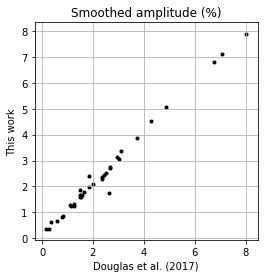

In [112]:
plt.figure(figsize=(4, 4))
for epic in smoothed_amps_fast: 
    plt.scatter(2*douglas.loc[epic]['SmAmp'], 100*smoothed_amps_fast[epic], marker='.', color='k')
plt.xlabel('Douglas et al. (2017)')
plt.ylabel('This work')
plt.title('Smoothed amplitude (%)')
plt.grid()
plt.savefig('plots/amps_morris_fast.pdf', bbox_inches='tight')

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


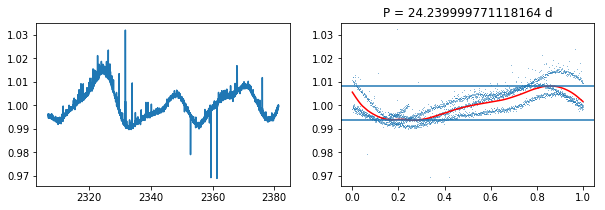

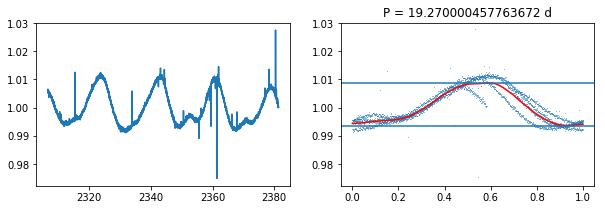

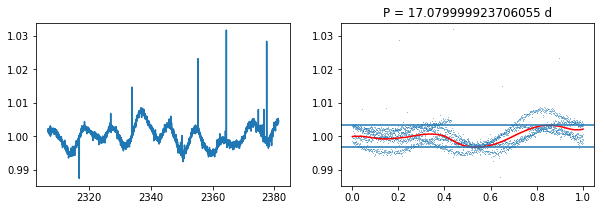

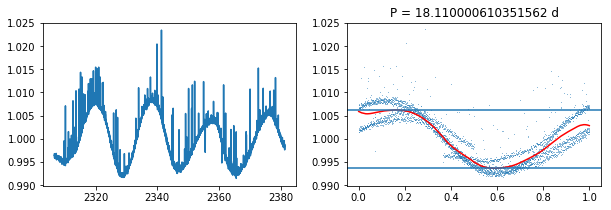

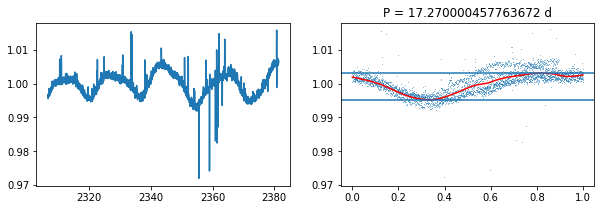

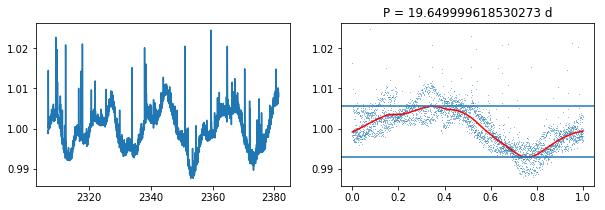

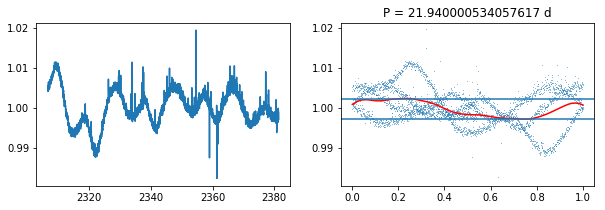

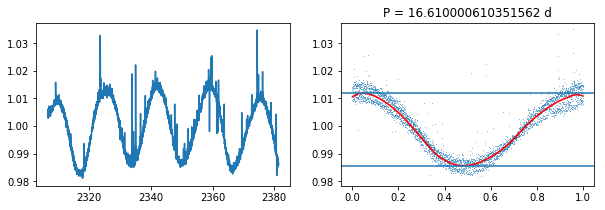

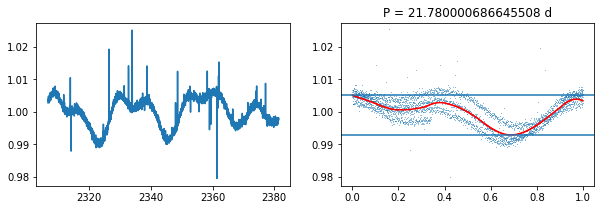

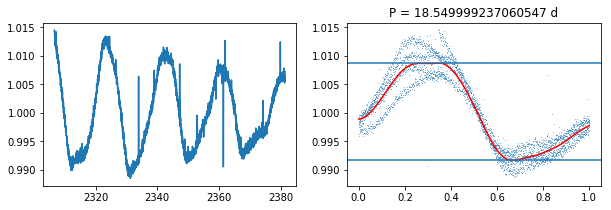

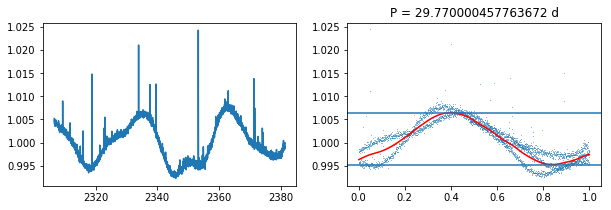

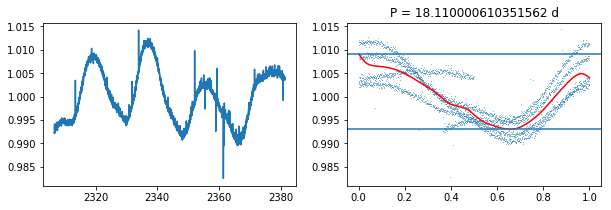

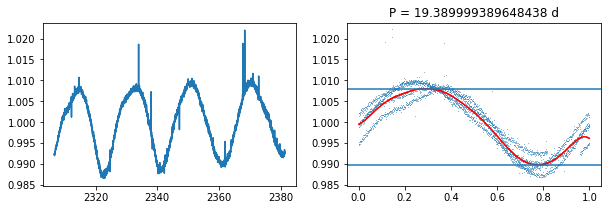

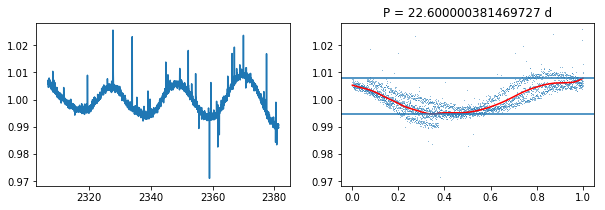

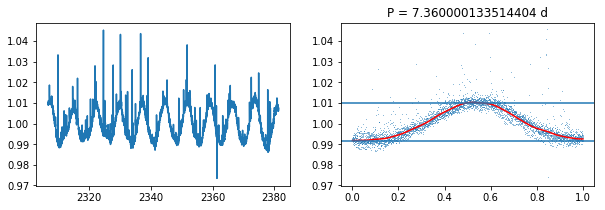

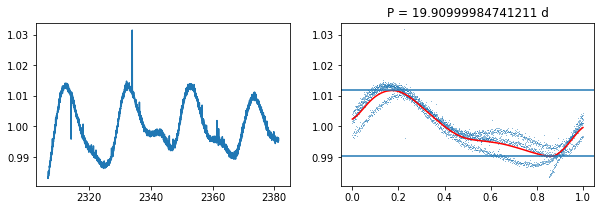

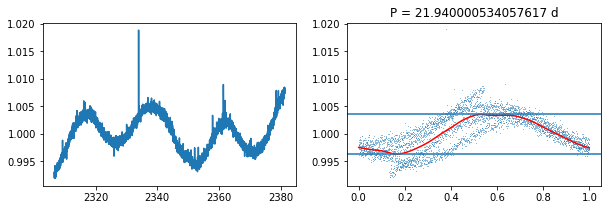

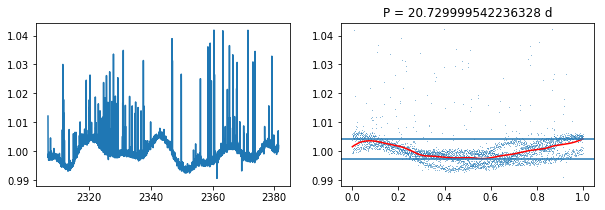

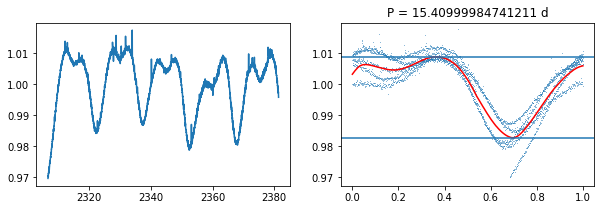

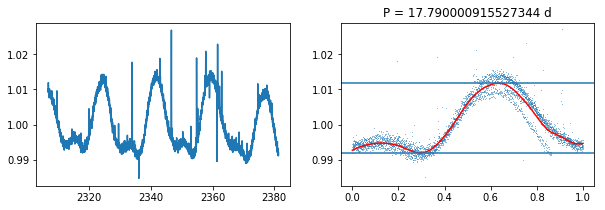

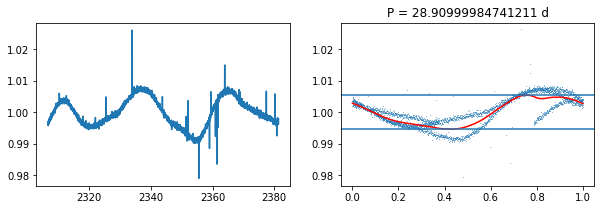

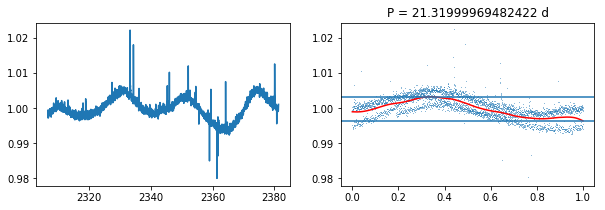

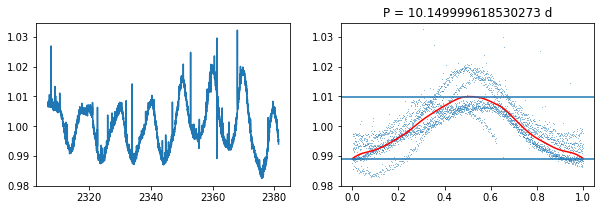

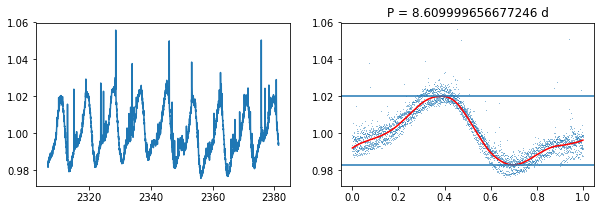

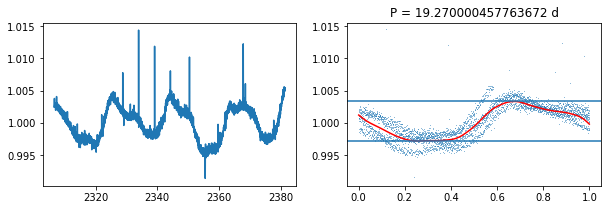

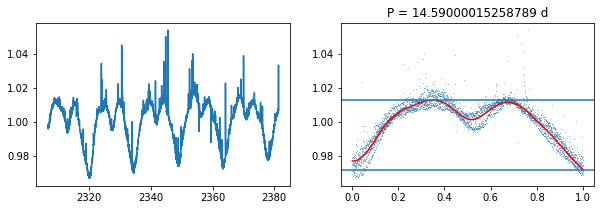

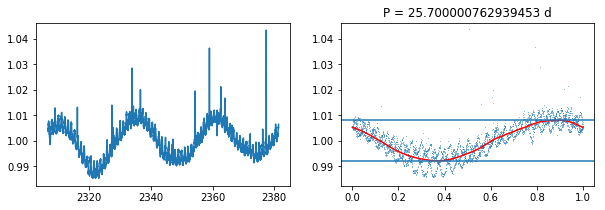

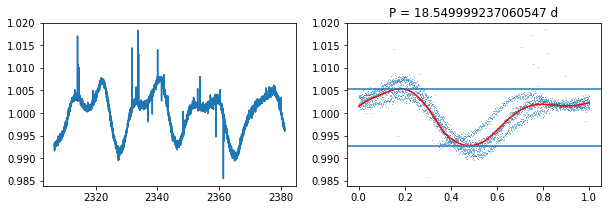

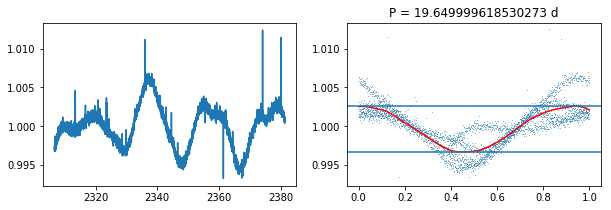

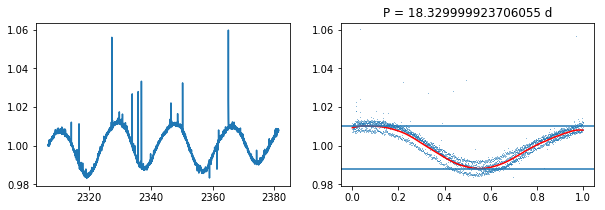

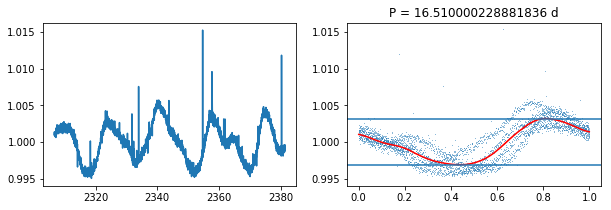

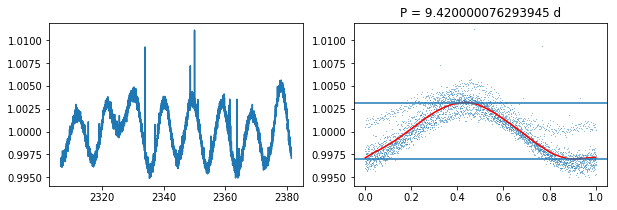

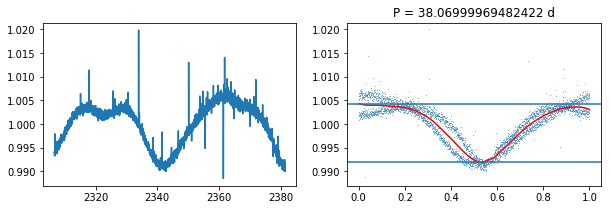

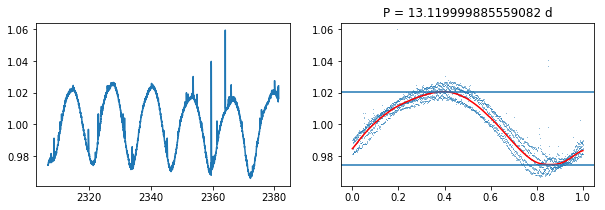

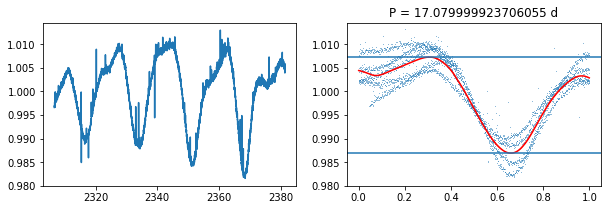

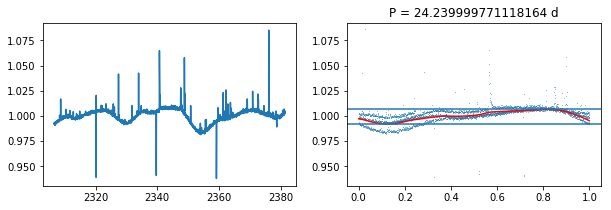

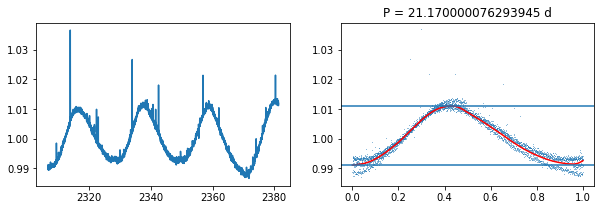

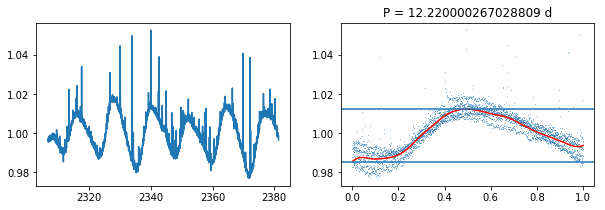

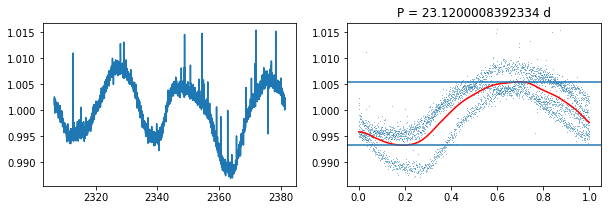

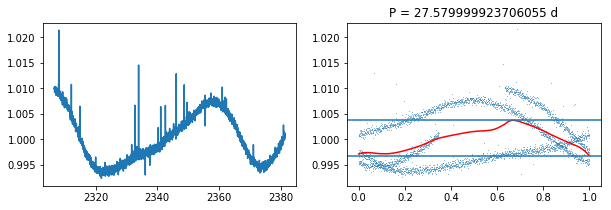

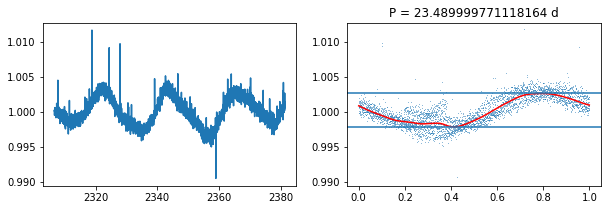

In [106]:
plots = True
smoothed_amps_slow = dict()
for i in range(len(slow)): 
    times, fluxes = np.load("data/{0}.npy".format(int(slow[i])))
    clipped = ~np.isnan(fluxes)
    clipped &= np.abs(fluxes - np.nanmedian(fluxes)) < 5*mad_std(fluxes, ignore_nan=True)
    times, fluxes = times[clipped], fluxes[clipped]

    # Remove polynomial trend
    fit = np.polyval(np.polyfit(times-times.mean(), fluxes, 2), times-times.mean())
    fluxes /= fit
    
    period = douglas.loc[slow[i]]['Prot1']

    phases = (times % period) / period
    
    sort = np.argsort(phases)
    #smoothed = gaussian_filter1d(fluxes[sort], 50, mode='nearest')
    smoothed = gaussian_filter1d(fluxes[sort], 100, mode='nearest')
        
    smoothed_amps_slow[slow[i]] = smoothed.max() - smoothed.min()
    
    if plots: 
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].plot(times, fluxes)
        ax[1].plot(phases, fluxes, ',', alpha=0.5)
        ax[1].plot(phases[sort], smoothed, 'r')

        ax[1].axhline(smoothed.min())
        ax[1].axhline(smoothed.max())
        ax[1].set_title("P = {0} d".format(period))

    plt.show()

In [114]:
np.savetxt('data/morris_amps_slow.txt', 100*np.array([smoothed_amps_slow[i] for i in smoothed_amps_slow]))

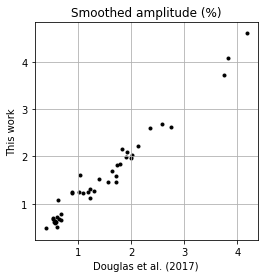

In [113]:
plt.figure(figsize=(4, 4))
for epic in smoothed_amps_slow: 
    plt.scatter(2*douglas.loc[int(epic)]['SmAmp'], 100*smoothed_amps_slow[epic], marker='.', color='k')
plt.grid()
plt.xlabel('Douglas et al. (2017)')
plt.ylabel('This work')
plt.title('Smoothed amplitude (%)')
plt.savefig('plots/amps_morris_slow.pdf', bbox_inches='tight')

In [109]:
len(smoothed_amps_slow), len(smoothed_amps_fast)

(41, 35)